# PoCS2 Assignment 13
## Tony Barrows

In [179]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from IPython.core.display import HTML

## Download Gutenberg text files.

In [19]:
text_urls = {
    'pride_prej': 'https://www.gutenberg.org/ebooks/1342.txt.utf-8',
    'frankenstein': 'https://www.gutenberg.org/cache/epub/84/pg84.txt',
    'moby_dick': 'https://www.gutenberg.org/cache/epub/2701/pg2701.txt'
}

def download_gutenberg(text_urls: dict, download_dir = '../data/01_raw/gutenberg/') -> None:

    query_parameters = {'downloadformat': 'txt'}
    for name, url in text_urls.items():
        response = requests.get(url, params=query_parameters)
        
        # write to disk
        outfile = download_dir + name + '.txt'
        with open(outfile, mode='w') as file:
            file.write(response.text)

download_gutenberg()

Move to text editor for some manual work.

In [142]:
def load_gutenberg(text_urls: dict, dir = '../data/02_intermediate/gutenberg_edited/') -> dict:

    def _read_file(fname, dir):
        fpath = dir + fname

        with open(fpath, mode='r', encoding='utf-8-sig') as file:
            txt = file.read()
        
        return txt

    texts = {}
    for key in text_urls.keys():
        fname = key + '_edited.txt'
        texts[key] = _read_file(fname, dir)

    return texts

texts = load_gutenberg(text_urls)

In [143]:
# quick helper function for displaying text in a legible way

def format(s, N=5000):
    '''Return first N characters as formatted text.'''
    s = s[0:N]
    return HTML(s)

## Parse Text Files

Let's start with Frankenstein

In [145]:
t = texts['frankenstein']
format(t, N=1000)

<IPython.core.display.HTML object>

Basic goal: separate the whole text into a list of 1-grams composed of words, punctuation, and numbers.

In [160]:
def parse_text(t):
    '''Return text corpus separated into 1-grams.'''

    # Frankenstein thing
    t = re.sub(r'D--n', r'Damn', t)

    # remove dashes with a period following
    t = re.sub(r'—.', r'', t)

    # separate punctuation
    t = re.sub(r'(?=[.,!?:;])', r' ', t)

    # deal with brackets and such
    t = re.sub(r'(?<=[\(\[])', r' ', t)
    t = re.sub(r'(?=[\)\]])', r' ', t)

    # deal with quotes
    t = re.sub(r'(?=[”])', r' ', t)
    t = re.sub(r'(?<=[“\'])', r' ', t)
    t = re.sub(r'\'s', ' \'s', t) # possession

    # dash madness
    t = re.sub(r'----', r' --- ', t)
    t = re.sub(r'--', r' --- ', t)
    t = re.sub(r';-', r' --- ', t)
    t = re.sub(r'—', r' --- ', t)

    ## TODO make this handle "Mr" and "Mrs" with no period
    # handle specific salutations
    t = re.sub(r'Mr .', r'Mr.', t)
    t = re.sub(r'Mrs .', r'Mrs.', t)
    t = re.sub(r'Dr .', r'Dr.', t)

    # remove underscores used for emphasis
    t = re.sub(r'_', r'', t)

    # remove string control
    t = re.sub(r'[\n\r\t]', ' ' , t)

    # remove additional whitespaces
    t = re.sub(r'\s+', ' ', t)

    return t

def write_parsed(t, fname, dir = '../data/02_intermediate/gutenberg_parsed/'):

    fpath = dir + fname
    with open(fpath, mode='w', encoding='utf-8-sig') as file:
        file.write(t)

def make_parsed_files(texts: dict, write_sample=True, n_samples=5000):

    parsed_text = {}
    for k, v in texts.items():

        fname = k + '_parsed.txt'
        parsed_text[k] = parse_text(v)

        # output a few examples
        if write_sample:
            write_parsed(parsed_text[k][0:n_samples], fname)
    
    return parsed_text

parsed_text = make_parsed_files(texts)

## Produce Size Rank Distributions

In [169]:
def make_size_rank_dist(text, fname, limit_top_n=None, write_file=True, 
                        filepath = '../data/03_primary/gutenberg_size_rank/') -> list:

    onegrams = text.split()
    counts = Counter(onegrams)

    # sort
    if limit_top_n:
        counts = counts.most_common(limit_top_n)
    else:
        counts = counts.most_common()

    if write_file:
        fpath = filepath + fname
        with open(fpath, 'w') as file:
            for k, v in counts:
                file.write("{}\t{}\n".format(k, v))

    return counts


def distributions_from_dict(text_dict, limit_top_n=None, write_file=True):

    if limit_top_n:
        file_ext = '_top_' + str(limit_top_n) + '_sizerank.txt'
    else:
        file_ext = "_sizerank.txt"

    sizerank = {}
    for k, v in text_dict.items():

        fname = k + file_ext
        sizerank[k] = make_size_rank_dist(v, fname, limit_top_n=limit_top_n,
                                          write_file=write_file)
    
    return sizerank

sizerank = distributions_from_dict(parsed_text, write_file=True)
sizerank100 = distributions_from_dict(parsed_text, limit_top_n=100, write_file=True)
list(sizerank)


['pride_prej', 'frankenstein', 'moby_dick']

## Make rank-count distributions plots

In [191]:
def make_dataframe_from_sizerank(sizerank) -> pd.DataFrame:

    df = pd.DataFrame()

    for k, v in sizerank.items():
        tmp = pd.DataFrame(v, columns=['ngram', 'count'])
        tmp.insert(0, 'source', k)
        tmp = tmp.reset_index(names = ['rank'])

        df = pd.concat([df, tmp])
    
    return df

df = make_dataframe_from_sizerank(sizerank)
df


,rank,source,ngram,count
0,0,pride_prej,",",9492
1,1,pride_prej,.,5112
2,2,pride_prej,to,4107
3,3,pride_prej,the,4076
4,4,pride_prej,of,3618
...,...,...,...,...
21387,21387,moby_dick,padlocks,1
21388,21388,moby_dick,sheathed,1
21389,21389,moby_dick,devious-cruising,1
21390,21390,moby_dick,retracing,1


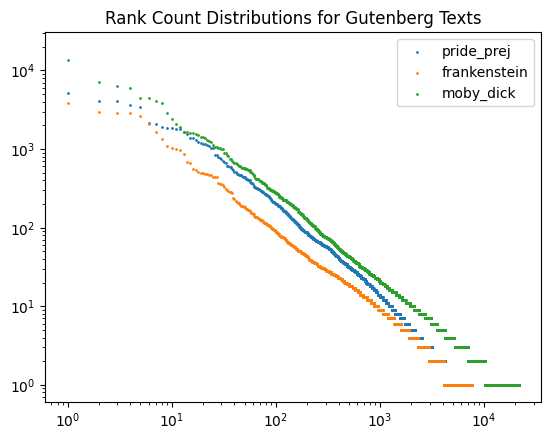

In [215]:
sources = pd.unique(df['source'])

for source in sources:

    tmp = df[df['source'] == source]
    plt.scatter(
        tmp['rank'], 
        tmp['count'],
        s=1
        )
    
plt.legend(sources)
plt.xscale('log')
plt.yscale('log')
plt.title('Rank Count Distributions for Gutenberg Texts')

plt.savefig(
    '../data/08_reporting/assign13_gutenberg_rankcount.png', 
    dpi=300, 
    bbox_inches='tight'
    )


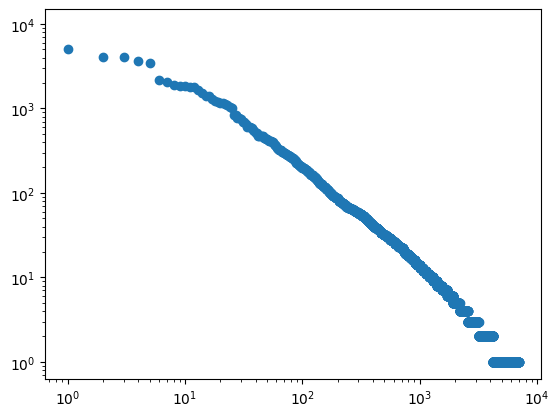